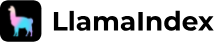

https://www.llamaindex.ai/

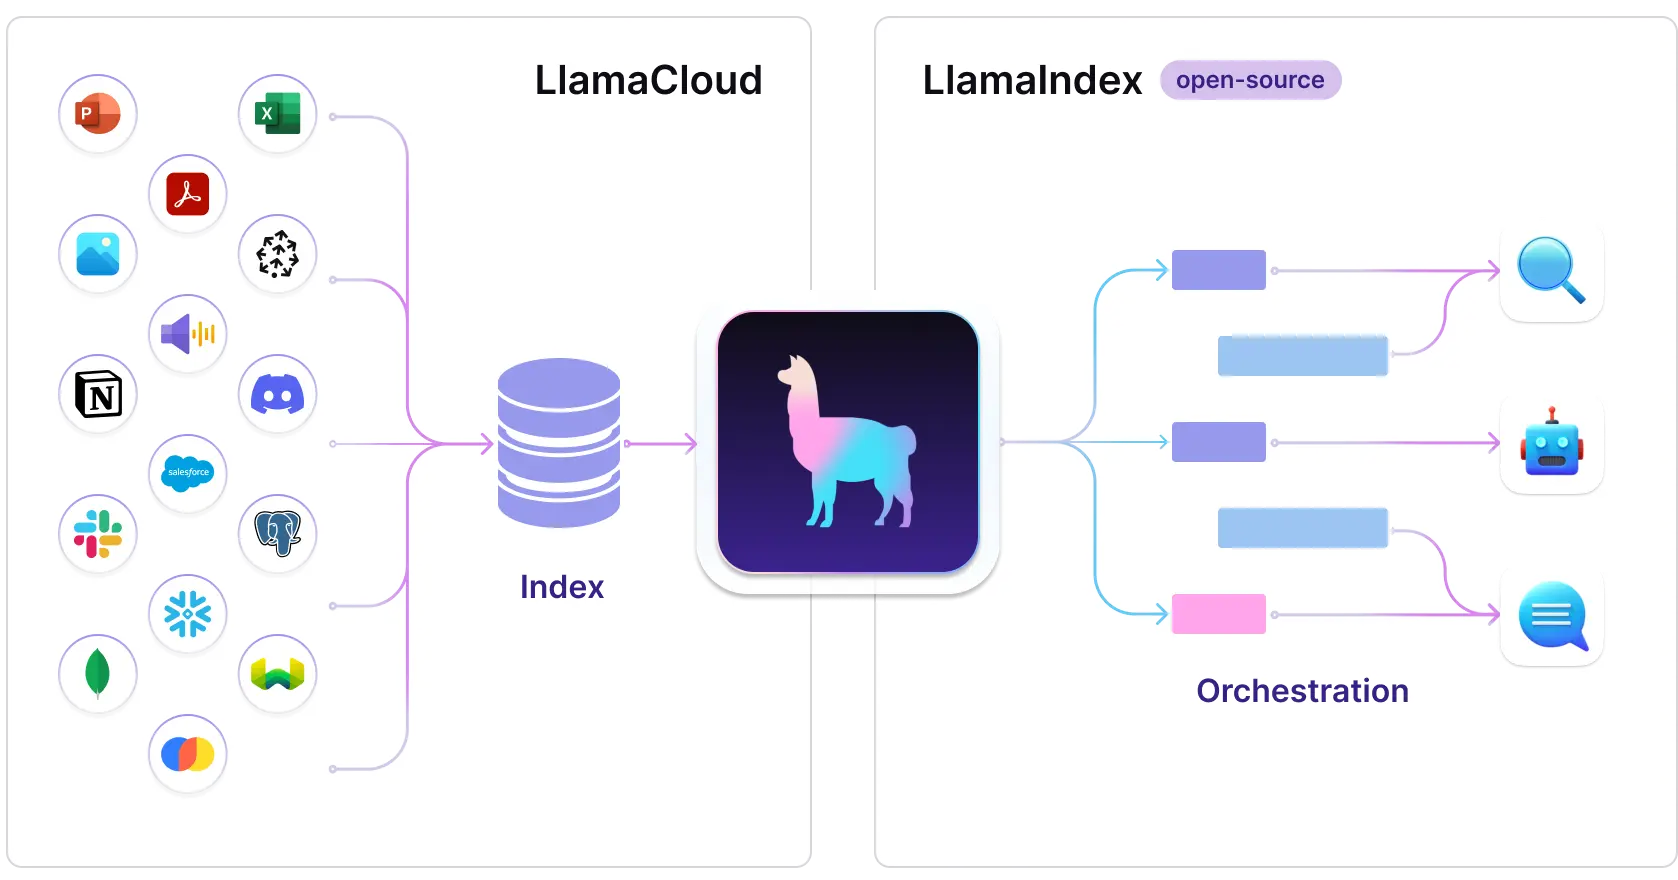

https://www.eum.go.kr/web/in/pd/pdBoardList.jsp?subType=C

In [ ]:
!pip install llama-index
!pip install langchain_community

In [ ]:

import logging
import sys

from llama_index.core import VectorStoreIndex, SimpleDirectoryReader,GPTVectorStoreIndex, ServiceContext
from llama_index.core.prompts.prompts import QuestionAnswerPrompt, RefinePrompt

from langchain.chat_models import ChatOpenAI
import os

import warnings

In [ ]:

warnings.filterwarnings('ignore')


# 로깅 설정을 스크립트의 가장 위에 위치
logging.getLogger('httpcore').setLevel(logging.WARNING)
logging.getLogger('httpx').setLevel(logging.WARNING)
logging.getLogger('llama_index').setLevel(logging.WARNING)

# 필요한 경우, 전체 로깅 레벨 설정
logging.basicConfig(level=logging.WARNING)


In [ ]:
os.environ['OPENAI_API_KEY'] = 'OPENAI_API_KEY'
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG, force=True)

In [ ]:
!wget "https://hycms.hanyang.ac.kr/index.php?module=xn_media_content2013&act=dispXn_media_content2013DownloadContent&content_id=674405596ad35" -O "pdf.zip"
!unzip  -O cp949 "pdf.zip" -d "pdf"


In [ ]:
documents = SimpleDirectoryReader('pdf', exclude_hidden=True, recursive=True).load_data()
index = GPTVectorStoreIndex.from_documents(documents)

In [ ]:


query_engine = index.as_query_engine()

# Text QA templates
BV_TEXT_QA_PROMPT_TMPL = (
    "도시군기본계획 내용을 바탕으로 답변합니다. \n"
    "아래는 답변을 위해 도시군기본계획에서 추출한 일부 내용입니다. \n"
    "---------------------\n"
    "{context_str}"
    "\n---------------------\n"
    "Given the context information answer the following question "
    "(if you don't know the answer, use the best of your knowledge): {query_str}\n"
    "답변은 한글로 하세요. 친절하게 답변바랍니다.\n"
    "관련 답변의 근거를 도시군기본계획의 어느 부분을 참고했는지 함께 알려줘요."
)
TEXT_QA_TEMPLATE = QuestionAnswerPrompt(BV_TEXT_QA_PROMPT_TMPL)

# Refine templates
BV_REFINE_PROMPT_TMPL = (
    "The original question is as follows: {query_str}\n"
    "We have provided an existing answer: {existing_answer}\n"
    "We have the opportunity to refine the existing answer "
    "(only if needed) with some more context below.\n"
    "------------\n"
    "{context_msg}\n"
    "------------\n"
    "Given the new context and using the best of your knowledge, improve the existing answer. "
    "If you can't improve the existing answer, just repeat it again.\n"
    "답변은 한글로 하세요. 친절하게 답변바랍니다."
    "관련 답변의 근거를 도시군기본계획의 어느 부분을 참고했는지 함께 알려줘요."
)
REFINE_TEMPLATE = RefinePrompt(BV_REFINE_PROMPT_TMPL)


In [ ]:

query_engine.get_prompts().keys()
query_engine.update_prompts({'response_synthesizer:text_qa_template': TEXT_QA_TEMPLATE})
query_engine.update_prompts({'response_synthesizer:refine_template': REFINE_TEMPLATE})

query_engine.get_prompts()



In [ ]:

user_query = '현재 안동시의 인구는 어떻게 되는지?'
answer = query_engine.query(user_query)

print(answer)


In [ ]:

user_query = '안동시의 도시군기본계획의 핵심 골자는?'
answer = query_engine.query(user_query)

print(answer)


In [ ]:

user_query = '안동시의 코로나 대응 방안'
answer = query_engine.query(user_query)

print(answer)


In [ ]:
# 인덱스의 벡터 저장소에서 모든 벡터와 노드 ID 가져오기
all_vectors = index.vector_store._data.embedding_dict

# 각 벡터와 해당 문서 내용 출력
idx = 0
for node_id, vector in all_vectors.items():
    # 노드 ID를 사용하여 문서 내용 조회
    node = index.docstore.get_node(node_id)
    text_content = node.get_text()
    print(f"Node ID: {node_id}")
    print(f"Vector: {vector}")
    print(f"Content: {text_content[:100]}")
    print("-" * 50)
    idx+=1
    if idx > 10 : break



In [ ]:

# 벡터와 텍스트 확인
all_vectors = index.vector_store._data.embedding_dict
idx = 0
for node_id, vector in all_vectors.items():
    node = index.docstore.get_node(node_id)
    print(f"Node ID: {node_id}")
    print(f"Vector: {vector}")
    if node is not None:
        print(f"Content: {node.get_text()[:100]}")
    else:
        print("Content not found for this Node ID")

    idx+=1
    if idx > 10 : break

In [ ]:
from llama_index.embeddings.openai import OpenAIEmbedding
from sklearn.metrics.pairwise import cosine_similarity


# Step 2: 벡터 저장소에서 PDF의 벡터 목록 추출
all_vectors = index.vector_store._data.embedding_dict  # 노드 ID와 벡터의 딕셔너리
all_node_ids = list(all_vectors.keys())  # 모든 노드 ID
all_vectors_array = list(all_vectors.values())  # 벡터 배열

# Step 3: User query 벡터화
embedding_model = OpenAIEmbedding()
user_query = "현재 안동시의 관광 계획"
query_vector = embedding_model.get_query_embedding(user_query)

# # Step 4: Query 벡터와 PDF 벡터 간 유사도 비교
# similarities = cosine_similarity([query_vector], all_vectors_array)[0]

# # Step 5: 가장 유사한 벡터 및 관련 텍스트 찾기
# most_similar_idx = similarities.argmax()
# most_similar_node_id = all_node_ids[most_similar_idx]
# most_similar_node = index.docstore.get_node(most_similar_node_id)

# Step 4: Query 벡터와 PDF 벡터 간 유사도 비교
threshold = 0.85  # 출력할 유사도 임계값 설정
similarities = cosine_similarity([query_vector], all_vectors_array)[0]

# Step 5: 유사도가 threshold 이상인 벡터 및 관련 텍스트 출력
print(f"User Query: {user_query}")
print("Results with Similarity above Threshold:")
print("-" * 50)

for idx, similarity in enumerate(similarities):
    if similarity >= threshold:
        node_id = all_node_ids[idx]
        node = index.docstore.get_node(node_id)
        text_title = node.get_text().split("\n")[0]
        page = node.metadata["page_label"]
        print(f"Node ID: {node_id}")
        print(f"Similarity Score: {similarity}")
        print(f"Content: [{page} page]{text_title}")
        print("-" * 50)


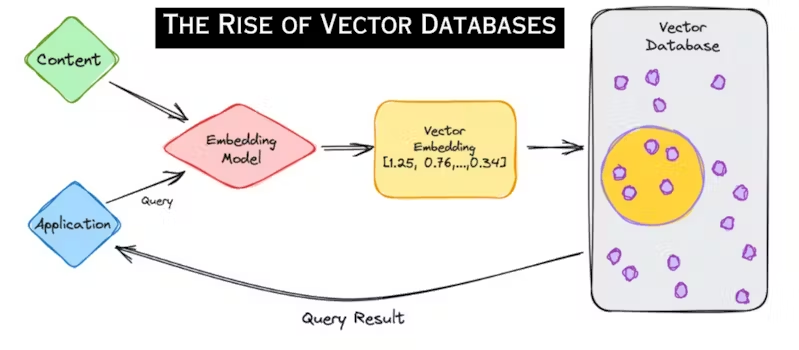

https://www.mongodb.com/ko-kr/resources/basics/databases/vector-databases

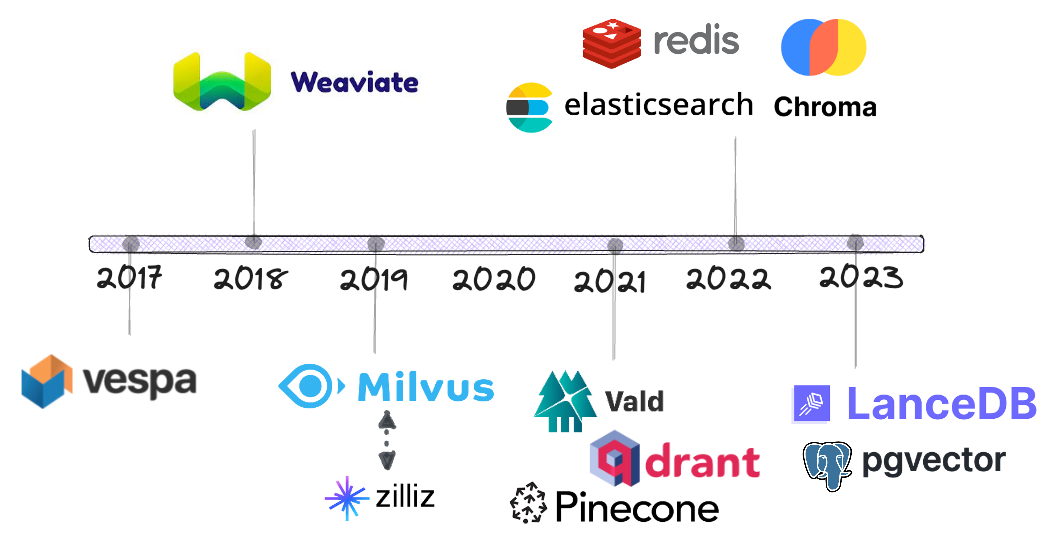

https://thedataquarry.com/posts/vector-db-1/